# Batch normalization folding on Post Training Quantization of SpeechBrain CRDNN on GPU


This notebook provides code for batch normalization folding on a post training quantized speechbrain/asr-crdnn-rnnlm-librispeech model.

First, let's install `datasets`,  `transformers` and `librosa`.

In [1]:
# %%capture
!pip install datasets==1.18.3
!pip install transformers==4.17.0
!pip install jiwer
!pip install librosa

In [1]:
device = 'cuda'

Next, we install `TensorRT` from source to use its tool `pytorch-quantization` for GPU quantization.

In [3]:
! git clone https://github.com/NVIDIA/TensorRT.git

In [4]:
! cd TensorRT/tools/pytorch-quantization && pip install .

In [5]:
! pip install --upgrade tensorrt

## Prepare Data, Tokenizer, Feature Extractor

In [ ]:
from datasets import load_dataset, load_metric

# Dataset is downloaded from https://www.openslr.org/12
data = load_dataset("LibriSpeech")

In [3]:
# from parse_data import parse_to_json
import json
import os

parse_to_json("./LibriSpeech/dev-clean")
os.rename('data.json', 'dev-clean.json')
with open('dev-clean.json', 'r') as file:
    dev_clean_data = json.load(file)

parse_to_json("./LibriSpeech/test-clean")
os.rename('data.json', 'test-clean.json')
with open('test-clean.json', 'r') as file:
    test_clean_data = json.load(file)

In [4]:
dev_clean_dict = {}
for key, value in dev_clean_data.items():
    new_key = key.replace('-', '')
    dev_clean_dict[new_key] = value

In [5]:
test_clean_dict = {}
for key, value in test_clean_data.items():
    new_key = key.replace('-', '')
    test_clean_dict[new_key] = value

In [6]:
import soundfile as sf
import resampy

def flac_to_array_with_sampling_rate(file_path, target_sr=16000):
    data, sr = sf.read(file_path, dtype='float32')

    if sr != target_sr:
        data = resampy.resample(data, sr, target_sr)

    return data

In [7]:
import re
chars_to_ignore_regex = '[\,\?\.\!\-\;\:\"]'

def remove_special_characters_dev(batch):
    batch["text"] = re.sub(chars_to_ignore_regex, '', batch["text"]).lower() + " "
    trimmed_string = batch["text"].strip()
    words = trimmed_string.split()
    new_text = ' '.join(words[1:])
    batch["text"] = new_text
    batch["input_values"] = flac_to_array_with_sampling_rate(dev_clean_dict[words[0]]['file_path'])
    return batch

In [ ]:
data['validation'] = data['validation'].map(remove_special_characters_dev)

In [9]:
import re
chars_to_ignore_regex = '[\,\?\.\!\-\;\:\"]'

def remove_special_characters_test(batch):
    batch["text"] = re.sub(chars_to_ignore_regex, '', batch["text"]).lower() + " "
    trimmed_string = batch["text"].strip()
    words = trimmed_string.split()
    new_text = ' '.join(words[1:])
    batch["text"] = new_text
    batch["input_values"] = flac_to_array_with_sampling_rate(test_clean_dict[words[0]]['file_path'])
    return batch

In [10]:
data['test'] = data['test'].map(remove_special_characters_test)

0ex [00:00, ?ex/s]

## Base Model

In [11]:
from speechbrain.pretrained import EncoderDecoderASR

In [12]:
asr_model = EncoderDecoderASR.from_hparams(source="speechbrain/asr-crdnn-rnnlm-librispeech", savedir="pretrained_models/speechbrain/asr-crdnn-rnnlm-librispeech", run_opts={"device":"cuda"})

In [13]:
import torch
with torch.no_grad():
    features = asr_model.mods.encoder.compute_features(torch.tensor(data['validation'][:1]['input_values']).cuda())

In [ ]:
torch.onnx.export(asr_model.mods.encoder.model,
             args=features.cuda(),
             f="asr-crdnn-encoder_librispeech.onnx",
             export_params=True,
             opset_version=17,
             do_constant_folding=True,
             input_names = ['modelInput'],
             output_names = ['modelOutput'],
             dynamic_axes={'modelInput' : {0 : 'batch_size', 1: 'batch_size'},
             'modelOutput' : {0 : 'batch_size'}}
)

## Post Training Quantization and Batch Normalization Folding

In [15]:
from pytorch_quantization import nn as quant_nn
from pytorch_quantization import quant_modules
from pytorch_quantization.tensor_quant import QuantDescriptor
from pytorch_quantization import calib

In [16]:
model_quantized = EncoderDecoderASR.from_hparams(source="speechbrain/asr-crdnn-rnnlm-librispeech", savedir="pretrained_models/speechbrain/asr-crdnn-rnnlm-librispeech", run_opts={"device":"cuda"})

In [17]:
quant_desc_input = QuantDescriptor(calib_method='max', num_bits=8, fake_quant=True)
quant_desc_weight = QuantDescriptor(num_bits=8, axis=(0))
quant_nn.QuantConv1d.set_default_quant_desc_input(quant_desc_input)
quant_nn.QuantConv1d.set_default_quant_desc_weight(quant_desc_weight)
quant_nn.QuantLinear.set_default_quant_desc_input(quant_desc_input)
quant_nn.QuantLinear.set_default_quant_desc_weight(quant_desc_weight)

In [18]:
quant_modules.initialize()
model_full_quantized = EncoderDecoderASR.from_hparams(source="speechbrain/asr-crdnn-rnnlm-librispeech", savedir="pretrained_models/speechbrain/asr-crdnn-rnnlm-librispeech", run_opts={"device":"cuda"})

In [19]:
for name, module in model_full_quantized.mods.encoder.model.DNN.named_modules():
    if name.endswith('_weight_quantizer'):
        module.enable_calib()
        module.disable_quant()

for name, module in model_full_quantized.mods.encoder.model.CNN.named_modules():
    if name.endswith('_weight_quantizer'):
        module.enable_calib()
        module.disable_quant()

In [ ]:
import torch
with torch.no_grad():
    for i in range(2000):
            _ = model_full_quantized(torch.tensor(data['validation'][i:i+1]["input_values"]).cuda(), torch.tensor([1.0]).to('cuda'))

In [ ]:
# Finalize calibration

for name, module in model_full_quantized.mods.encoder.model.named_modules():
    if name.endswith('_weight_quantizer'):
        module.load_calib_amax()
        module.disable_calib()
        module.enable_quant()

model_full_quantized = model_full_quantized.cuda()

Perform batch normalization folding in DNN:

In [23]:
import torch
from torch import nn

def fuse(linear, bn):
    w = linear.weight
    mean = bn.running_mean
    var_sqrt = torch.sqrt(bn.running_var + bn.eps)

    beta = bn.weight
    gamma = bn.bias

    if linear.bias is not None:
        b = linear.bias
    else:
        b = mean.new_zeros(mean.shape)

    w = w.cuda()
    b = b.cuda()
    w = w * (beta / var_sqrt).reshape([512, 1])
    b = (b - mean)/var_sqrt * beta + gamma
    fused_linear = nn.Linear(linear.in_features,
                         linear.out_features)

    fused_linear.weight = nn.Parameter(w)
    fused_linear.bias = nn.Parameter(b)
    return fused_linear

import copy

fused_linear_0 = copy.deepcopy(model_full_quantized.mods.encoder.model.DNN.block_0.linear.w)
bn_0 = model_full_quantized.mods.encoder.model.DNN.block_0.norm.norm

fused_linear_1 = copy.deepcopy(model_full_quantized.mods.encoder.model.DNN.block_1.linear.w)
bn_1 = model_full_quantized.mods.encoder.model.DNN.block_1.norm.norm

model_full_quantized.mods.encoder.model.DNN.block_0.linear.w = fuse(fused_linear_0, bn_0)
model_full_quantized.mods.encoder.model.DNN.block_0.norm = nn.Identity()

model_full_quantized.mods.encoder.model.DNN.block_1.linear.w = fuse(fused_linear_1, bn_1)
model_full_quantized.mods.encoder.model.DNN.block_1.norm = nn.Identity()

In [24]:
model_quantized.mods.encoder.model.DNN = model_full_quantized.mods.encoder.model.DNN
model_quantized.mods.encoder.model.CNN = model_full_quantized.mods.encoder.model.CNN

In [ ]:
torch.onnx.export(model_quantized.mods.encoder.model,
             args=features.cuda(),
             f="asr-crdnn-encoder-librispeech-quantized-bn-fused.onnx",
             export_params=True,
             opset_version=17,
             do_constant_folding=True,
             input_names = ['modelInput'],
             output_names = ['modelOutput'],
             dynamic_axes={'modelInput' : {0 : 'batch_size', 1: 'batch_size'},
             'modelOutput' : {0 : 'batch_size'}}
)

### Base vs Quantized Model Inference Time

In this section, we compare the inference time of the base model and the quantized model on the test data. Furthermore, we evalute the perfomance of the base and the quantized models using the word error rate (WER) metric.

**Inference**

In [ ]:
# ! pip install onnxruntime-gpu

In [26]:
import onnxruntime as ort
import tensorrt
ort.get_device()

'GPU'

In [27]:
# Load onnx models
ort_sess_base = ort.InferenceSession('asr-crdnn-encoder_librispeech.onnx')
ort_sess_quantized_bn_fused = ort.InferenceSession('asr-crdnn-encoder-librispeech-quantized-bn-fused.onnx', providers=['TensorrtExecutionProvider'])

2024-01-09 17:00:56.174650451 [W:onnxruntime:Default, tensorrt_execution_provider.h:77 log] [2024-01-09 17:00:56 WARNING] onnx2trt_utils.cpp:374: Your ONNX model has been generated with INT64 weights, while TensorRT does not natively support INT64. Attempting to cast down to INT32.
2024-01-09 17:01:03.433700718 [W:onnxruntime:Default, tensorrt_execution_provider.h:77 log] [2024-01-09 17:01:03 WARNING] onnx2trt_utils.cpp:374: Your ONNX model has been generated with INT64 weights, while TensorRT does not natively support INT64. Attempting to cast down to INT32.


In [28]:
import time
import numpy

def compute_inference_time(ort_sess, num_samples):
    model_time = 0
    with torch.no_grad():
        for single_batch in data["test"].select(range(num_samples)):
            initial_input = torch.tensor([single_batch["input_values"]]).cuda()
            features_input = asr_model.mods.encoder.compute_features(initial_input)
            input_values = torch.tensor(features_input, device="cpu")
            input_values = input_values.clone().detach().numpy().astype(numpy.float32)
            starttime = time.time()
            ort_sess.run(['modelOutput'], {'modelInput': input_values})
            model_time += time.time() - starttime
    return round(model_time/num_samples, 8)

In [49]:
num_samples = 50

base_model_time = compute_inference_time(ort_sess_base, num_samples)

In [30]:
print(f'Base Model inference time {base_model_time} seconds')

Base Model inference time 0.51867234 seconds


In [ ]:
quantized_bn_fused_time = compute_inference_time(ort_sess_quantized_bn_fused, num_samples)

In [51]:
print(f'Quantized model with folded batch normalization inference time {quantized_bn_fused_time} seconds')

Quantized model with fused batch normalization inference time 0.04393559 seconds


**Inference Time Visualisation of Results**

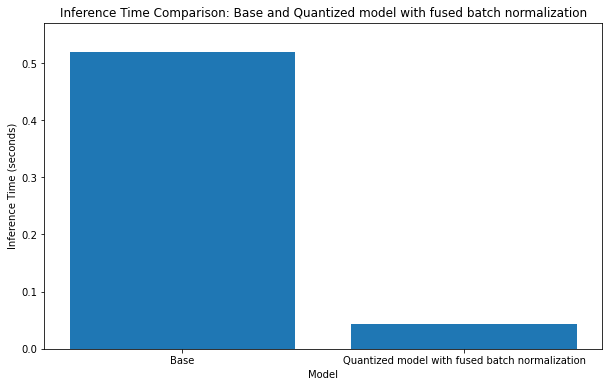

In [52]:
import matplotlib.pyplot as plt

models = ['Base', 'Quantized model with fused batch normalization',]
inference_times = [base_model_time, quantized_bn_fused_time]

plt.figure(figsize=(10, 6))
plt.bar(models, inference_times)
plt.xlabel('Model')
plt.ylabel('Inference Time (seconds)')
plt.title('Inference Time Comparison: Base and Quantized model with fused batch normalization')
plt.ylim(0, max(inference_times) * 1.1)
plt.show()

**Evaluating WER metric**

In [34]:
wer_metric = load_metric("wer")

In [35]:
def map_model_to_wer_result(model, single_batch):
    input_values = torch.tensor(single_batch["input_values"]).to('cuda')
    with torch.no_grad():
        prediction = model(input_values, torch.tensor([1.0]).to('cuda'))

    return wer_metric.compute(predictions=[prediction[0][0].lower()], references=single_batch['text'])

In [36]:
num_samples = len(data['test'])

In [42]:
total_wer = 0

for i in range(num_samples):
    total_wer += map_model_to_wer_result(asr_model, data['test'][i:i+1])

base_wer_result = round(total_wer / num_samples, 8)

In [43]:
print(f'Base Model WER: {base_wer_result}')

Base Model WER: 0.03518899


In [39]:
total_wer_quantized_bn_fused = 0

for i in range(num_samples):
    total_wer_quantized_bn_fused += map_model_to_wer_result(model_quantized,  data['test'][i:i+1])

quantized_bn_fused_wer_result = round(total_wer_quantized_bn_fused / num_samples, 8)

In [54]:
print(f'Quantized model with folded batch normalization WER: {quantized_bn_fused_wer_result}')

Quantized model with folded batch normalization WER: 0.0376953


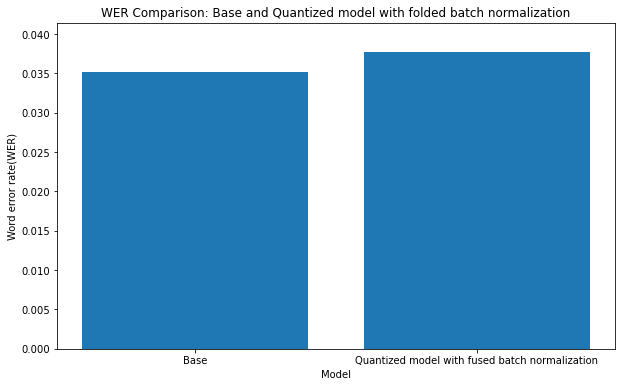

In [53]:
import matplotlib.pyplot as plt

models = ['Base', 'Quantized model with fused batch normalization']
inference_times = [base_wer_result, quantized_bn_fused_wer_result]

plt.figure(figsize=(10, 6))
plt.bar(models, inference_times)
plt.xlabel('Model')
plt.ylabel('Word error rate(WER)')
plt.title('WER Comparison: Base and Quantized model with folded batch normalization')
plt.ylim(0, max(inference_times) * 1.1)
plt.show()